In [2]:
from sympy import *
from matplotlib import pyplot as plt
import pandas as pd

In [25]:
def calc_prices():
    #need to implement with arguments and stuff
    for t1,t2 in [(-.14,.55),(-.07,1)]:
        p1 = (2*t1 + t2) / 3 + 1
        p2 = (2*t2 + t1) / 3 + 1
        print 'p1: %s , p2: %s, diff: %s'%(p1,p2, p2-p1)

        
calc_prices()

p1: 1.09 , p2: 1.32, diff: 0.23
p1: 1.28666666667 , p2: 1.64333333333, diff: 0.356666666667


In [26]:
#still in progress, need to compare nash bargaining objectives to each other. 
#make sure to check that they are not equal. maximum will not be strictly less than its self?

def find_eq(candidates,simult=True,v=False):
    solutions = []
    if len(candidates) == 1:
        return candidates
    for sol_0 in candidates:
        l_0,q_0,m1_0,m2_0,b1_0,b2_0,t1_0,t2_0,pi1_0,pi2_0 = sol_0
        
        pi1_l0 = S(.5)*( (t2_0-l_0)/S(3) +q_0)*(1 + (t2_0-l_0)/(S(3)*q_0) )
        pi2_l0 = S(.5)*( (t1_0-l_0)/S(3) +q_0)*(1 + (t1_0-l_0)/(S(3)*q_0) )

        v1_0 = (pi1_0 - pi1_l0)**(b1_0) * (m1_0*t1_0 +m2_0*t2_0)**(1-b1_0)
        v2_0 = (pi2_0 - pi2_l0)**(b2_0) * (m1_0*t1_0 +m2_0*t2_0)**(1-b2_0)
        if v: print 'pi1_l0: %s, pi2_l0: %s, pi1_0: %s, pi2_0: %s, v1_0: %s, v2_0: %s, t1_0: %s, t2_0: %s, \n'%(
            pi1_l0,pi2_l0,pi1_0,pi2_0,v1_0,v2_0,t1_0,t2_0)
        nash = True
        for sol in candidates:
            l,q,m1,m2,b1,b2,t1,t2,pi1,pi2 = sol  
            pi1_l = S(.5)*( (t2-l)/S(3) +q) *(1 + (t2-l)/(S(3)*q) )
            pi2_l = S(.5)*( (t1-l)/S(3) +q) *(1 + (t1-l)/(S(3)*q) )
                
            #nash bargaining objectives - non candidate
            v1 = (pi1 - pi1_l )**(b1) * (m1*t1 +m2*t2)**(1-b1)
            v2 = (pi2 - pi2_l )**(b2) * (m1*t1 +m2*t2)**(1-b2)
            v0_real =  v1_0.is_real and v2_0.is_real
            v_real =  v2.is_real and v1.is_real
            if v: print 'pi1: %s, pi2: %s, v1: %s, v2: %s , t1: %s, t2:%s \n'%(pi1, pi2, v1,v2,t1,t2)
            
            #solution depends on type of problem?
            if simult:
                nash = nash and v0_real and (not v_real or v1 < v1_0 or v2 <v2_0 or (v1 == v1_0 and v2 == v2_0))  
            else:
                nash = nash and v0_real and (not v_real or v1 < v1_0 or (v1 == v1_0 and v2 <= v2_0))
        if nash: 
            solutions.append(sol_0)
    return solutions

In [27]:
def inter_seq(t1,t2,h1_list,v2_foc,
                 l,q,m1,m2,b1,b2,pi1,pi2,v):
    solutions = []
    
    for h1 in h1_list:
        #susbitute h1 for t2, then substitute l into the second term for t1
        h1 = simplify(h1)
        pi1_h = pi1.subs(t2,h1)
        pi1_l = pi1_h.subs(t1,l)
        v1 = (pi1.subs(t2,h1) - pi1_l ) * (m1*t1 + m2*h1)
        v1_foc = diff(v1,t1)
        
        if v: print 'solving t1_foc ...'
        t1_sol = solve(v1_foc,t1,rational=False,force=True)
        t1_sol = [t1_cand for t1_cand in t1_sol if t1_cand.is_real]
        if v: print 't1_sol: %s\n'%t1_sol
        
        for t1_param in t1_sol:
            t2_param = h1.subs(t1,t1_param) 
            pi1_param = pi1.subs({t1:t1_param, t2:t2_param})
            pi2_param = pi2.subs({t1:t1_param, t2:t2_param})
            solutions.append((l,q,m1,m2,b1,b2,t1_param,t2_param,pi1_param,pi2_param))
    return solutions


def corner_seq(t1,t2, h1_list,v2_foc,
                  l,q,m1,m2,b1,b2,pi1,pi2,v):
    solutions = [(l,q,m1,m2,b1,b2,l,l,.5*q,.5*q)]
    #case 1: t1 = l
    for h1 in h1_list:
        t2_param = h1.subs(t1,l)
        pi1_param2 = S(.5)*( (t2_param-l)/S(3) +q) *(1 + (t2_param-l)/(S(3)*q) )
        pi2_param2 = S(.5)*( (l-t2_param)/S(3) +q) *(1 + (l-t2_param)/(S(3)*q) )
        solutions.append((l,q,m1,m2,b1,b2,l,t2_param,pi1_param2,pi2_param2))
    
    #case 2: h1 = t2 = l:
    pi1_h = pi1.subs(t2,l)
    pi1_l = pi1_h.subs(t1,l)
    v1 = (pi1.subs(t2,l) - pi1_l ) * (m1*t1 + m2*l)
    v1_foc = diff(v1,t1)
    
    if v: print 'solving t1_foc ...'
    t1_sol = solve(v1_foc,t1,rational=False,force=True)
    t1_sol = [t1_cand for t1_cand in t1_sol if t1_cand.is_real]
    if v: print 't1_sol: %s\n'%t1_sol
    
    for t1_param in t1_sol:
        pi1_param1 = S(.5)*( (l-t1_param)/S(3) +q) *(1 + (l-t1_param)/(S(3)*q) )
        pi2_param1 = S(.5)*( (t1_param-l)/S(3) +q) *(1 + (t1_param-l)/(S(3)*q) )
        solutions.append((l,q,m1,m2,b1,b2,t1_param,l,pi1_param1,pi2_param1))
        
    return solutions
    
    
def seq(t1=Symbol('t_1'),
           t2=Symbol('t_2'),
           l=Symbol('l'),
           q=Symbol('q'),
           m1=Symbol('m_1'),
           m2=Symbol('m_2'),
           b1=Symbol('b_1'),
           b2=Symbol('b_2'), v=False, inter=True,corner=True):   
    #profits
    pi1 = .5*( (t2-t1)/3 +q)*(1 + (t2-t1)/(3*q) )
    pi2 = .5*( (t1-t2)/3 +q)*(1 + (t1-t2)/(3*q) )

    #use SPE/backward induction to solve game
    v2 = (pi2 - pi2.subs(t2,l) )**(b2) * (m1*t1 +m2*t2)**(1-b2)
    v2_foc = diff(v2,t2)
    
    h1_list = solve(v2_foc,t2,force=True)
    if v: print 'h1_list: %s\n'%h1_list
    
    solutions = []
    #edge cases
    if corner:
        corner_solutions = corner_seq(t1,t2, h1_list, v2_foc,
                                     l,q,m1,m2,b1,b2,pi1,pi2,v)
        for sol in  corner_solutions:
            solutions.append(sol)
    #interior cases:
    if inter:
        int_solutions = inter_seq(t1,t2, h1_list, v2_foc,
                                 l,q,m1,m2,b1,b2,pi1,pi2,v)
        for sol in int_solutions:
            solutions.append(sol)        
    return solutions

test_seq1 = seq(l = 1, q = 1, m1 = .5, m2 = .5, b1 = .5, b2 = .5, v=False,inter=True,corner=False)
test_seq2 = seq(l = 1, q = 1, m1 = .5, m2 = .5, b1 = .5, b2 = .5, v=False,inter=False,corner=True)
print find_eq(test_seq1,simult=False)
print find_eq(test_seq2,simult=False)
#print find_eq(test_seq1+test_seq2,simult=False)

[(1, 1, 0.5, 0.5, 0.5, 0.5, -0.147145085939096, 0.551742350534693, 0.760098237094646, 0.294173279445454)]
[(1, 1, 0.5, 0.5, 0.5, 0.5, -0.0703675169759928, 1, 0.920438429069628, 0.206860084418966)]


In [12]:
def inter_simult(t1,t2,v1_foc,v2_foc,
                 l,q,m1,m2,b1,b2,pi1,pi2,v):
    solutions = []
    #solve for t2 as a function of t1
    if v: print 'interior solving v2_foc... \n'
    t2_sol = solve(v2_foc,t2)
    if v: print 'interior t2_sol: %s \n'%t2_sol 
    for t2_param in t2_sol:
        #substitute back into foc
        v1_foc1 = v1_foc.subs(t2,t2_param)  
        if v: print 'interior solving v1_foc... \n'
        t1_param = solve(v1_foc1,t1)        
        t1_param = [t1_cand for t1_cand in t1_param if t1_cand.is_real]
        if v: print 'interior t2_param: %s, t1_param: %s \n'%(t2_param, t1_param)  
        #sovle for t2
        t2_param = [t2_param.subs(t1, t1_cand) for t1_cand in t1_param]
        for i in range(len(t1_param)): 
            pi1_param = pi1.subs({t1:t1_param[i], t2:t2_param[i]})
            pi2_param = pi2.subs({t1:t1_param[i], t2:t2_param[i]})
            solutions.append((l,q,m1,m2,b1,b2,t1_param[i],t2_param[i],pi1_param,pi2_param))   
    return solutions


def corner_simult(t1,t2,v1_foc,v2_foc,
                  l,q,m1,m2,b1,b2,pi1,pi2,v):
    solutions = [(l,q,m1,m2,b1,b2,l,l,.5*q,.5*q)]
    
    #case 1: t2 = l, t1 interior (good one)
    v1_foc1 = v1_foc.subs(t2,l) 
    if v: print 'solving foc 1 in corner case... \n'
    t1_sol = solve(v1_foc1,t1)        
    t1_sol = [t_cand for t_cand in t1_sol if t_cand.is_real]
    if v: print 't1_sol in corner: %s \n'%(t1_sol)  
    #add solutions to list
    for t1_param in t1_sol:
        pi1_param1 = S(.5)*( (l-t1_param)/S(3) +q) *(1 + (l-t1_param)/(S(3)*q) )
        pi2_param1 = S(.5)*( (t1_param-l)/S(3) +q) *(1 + (t1_param-l)/(S(3)*q) )
        solutions.append((l,q,m1,m2,b1,b2,t1_param,l,pi1_param1,pi2_param1))

    #case 2: t1 = l, t2 interior (broken one)
    v2_foc2 = v2_foc.subs(t1,l) 
    if v: print 'solving foc 2 in corner case... \n'
    t2_sol = solve(v2_foc2,t2)        
    t2_sol = [t_cand for t_cand in t2_sol if t_cand.is_real]
    if v: print 't2_sol in corner: %s \n'%(t2_sol)  
    #add solutions to list
    for t2_param in t2_sol:
        pi1_param2 = S(.5)*( (t2_param-l)/S(3) +q) *(1 + (t2_param-l)/(S(3)*q) )
        pi2_param2 = S(.5)*( (l-t2_param)/S(3) +q) *(1 + (l-t2_param)/(S(3)*q) )
        solutions.append((l,q,m1,m2,b1,b2,l,t2_param, pi1_param2,pi2_param2))
    
    return solutions


def simult(t1=Symbol('t_1'),
           t2=Symbol('t_2'),
           l=Symbol('l'),
           q=Symbol('q'),
           m1=Symbol('m_1'),
           m2=Symbol('m_2'),
           b1=Symbol('b_1'),
           b2=Symbol('b_2'), v=False, inter=True,corner=True):
    
    #profits
    pi1 = S(.5)*( (t2-t1)/S(3) +q)*(S(1) + (t2-t1)/(S(3)*q) )
    pi2 = S(.5)*( (t1-t2)/S(3) +q)*(S(1) + (t1-t2)/(S(3)*q) )
    #nash bargaining objectives
    v1 = (pi1 - pi1.subs(t1,l) )**(b1) * (m1*t1 +m2*t2)**(S(1)-b1)
    v2 = (pi2 - pi2.subs(t2,l) )**(b2) * (m1*t1 +m2*t2)**(S(1)-b2)
    #simultaneous bargaining
    v1_foc = diff(v1,t1)
    v2_foc = diff(v2,t2)
    #initialize no bargain, list price both
    solutions = []
    #other less important cases:
    if corner:
        corner_solutions = corner_simult(t1,t2, v1_foc, v2_foc,
                                     l,q,m1,m2,b1,b2,pi1,pi2,v)
        for sol in  corner_solutions:
            solutions.append(sol)
    #interior cases:
    if inter:
        int_solutions = inter_simult(t1,t2,v1_foc,v2_foc,
                                 l,q,m1,m2,b1,b2,pi1,pi2,v)
        for sol in int_solutions:
            solutions.append(sol)
    return solutions

test_sim1 = simult(l = 6.2, q = 1, m1 = .5, m2 = .5, b1 = .5, b2 = .5, v=False, inter=True, corner=True)
print test_sim1

[(6.2, 1, 0.5, 0.5, 0.5, 0.5, 6.2, 6.2, 0.5, 0.5), (6.2, 1, 0.5, 0.5, 0.5, 0.5, -1.35099990770935, 6.2, 6.18464439180459, 1.15064445333169), (6.2, 1, 0.5, 0.5, 0.5, 0.5, 9.48433324104268, 6.2, 0.00449141066454633, 2.19404690469300), (6.2, 1, 0.5, 0.5, 0.5, 0.5, 6.2, -1.35099990770935, 1.15064445333169, 6.18464439180459), (6.2, 1, 0.5, 0.5, 0.5, 0.5, 6.2, 9.48433324104268, 2.19404690469300, 0.00449141066454633), (6.2, 1, 0.5, 0.5, 0.5, 0.5, -5.36904651573303, -5.36904651573303, 0.500000000000000, 0.500000000000000), (6.2, 1, 0.5, 0.5, 0.5, 0.5, -0.230953484266974, -0.230953484266974, 0.500000000000000, 0.500000000000000), (6.2, 1, 0.5, 0.5, 0.5, 0.5, 4.07081449998276, -0.390814499982760, 0.118686629641123, 3.09310596295147), (6.2, 1, 0.5, 0.5, 0.5, 0.5, -0.390814499982760, 4.07081449998276, 3.09310596295147, 0.118686629641123)]


In [29]:
def l_plotter(game, ranger, scaler, args, corner=True, simult=True, v=False):
    q0, m10, m20, b10, b20 = args
    result = []
    for l in ranger: 
        l = l/scaler
        solutions = game(l = l ,q = q0, m1 = m10, m2 = m20, b1 = b10, b2 = b20, corner= corner)
        solutions = find_eq(solutions, simult = simult)
        if v: print 'solutions: %s \n'%solutions
        for sol in solutions:
            result.append(sol) 
    result = pd.DataFrame(result, columns=['l','lambda','mu_1','mu_2','beta_1','beta_2','theta_1','theta_2','pi_1','pi_2']) 
    return result


def q_plotter(game, ranger, scaler, args, corner=True, simult=True, v=False): 
    l0, m10, m20, b10, b20  = args 
    result = [] 
    for q in ranger: 
        q = q/scaler 
        solutions = game(l = l0 ,q = q, m1 = m10, m2 = m20, b1 = b10, b2 = b20,  corner= corner)
        solutions = find_eq(solutions , simult = simult)
        if v: print 'solutions: %s \n'%solutions
        for sol in solutions:
            result.append(sol) 
    result = pd.DataFrame(result, columns=['l','lambda','mu_1','mu_2','beta_1','beta_2','theta_1','theta_2','pi_1','pi_2'])
    return result


def m_plotter(game, ranger, scaler, args, corner=True, simult=True, v=False): 
    q0, l0, m20, b10, b20  = args 
    result = [] 
    for m in ranger:
        m = m/scaler 
        if v: print 'l: %s, q: %s, m1: %s, m2: %s, b1: %s, b2: %s \n'%(l0 ,q0, m, m20,  b10, b20)
        solutions = game(l = l0 ,q = q0, m1 = m, m2 = m20, b1 = b10, b2 = b20, corner= corner)
        if v: print '(unfiltered) solutions: %s \n'%solutions
        solutions = find_eq(solutions , simult = simult)
        if v: print 'solutions: %s \n'%solutions
        for sol in solutions:
            result.append(sol) 
    result = pd.DataFrame(result, columns=['l','lambda','mu_1','mu_2','beta_1','beta_2','theta_1','theta_2','pi_1','pi_2'])
    return result

In [14]:
def quick_plot(frame,ptype,fname):
    #plot pi
    fig = plt.figure()
    fig.suptitle('pi  vs %s'%ptype)
    plt.ylabel('pi(%s)'%ptype)
    plt.xlabel(ptype)
    plt.plot(frame[ptype] ,frame['pi_1'], 'ro')
    plt.plot(frame[ptype] ,frame['pi_2'], 'bo')
    fig.savefig('plots/%s_pi_%s'%(fname,ptype))
    
    #plot theta
    fig = plt.figure()
    fig.suptitle('theta  vs %s'%ptype)
    plt.ylabel('theta(%s)'%ptype)
    plt.xlabel(ptype)
    plt.plot(frame[ptype] ,frame['theta_1'], 'ro')
    plt.plot(frame[ptype] ,frame['theta_2'], 'bo')
    fig.savefig('plots/%s_theta_%s'%(fname,ptype))

In [30]:
arg0 =  (1, .5,.5,.5,.5)
simult1_l =  l_plotter(simult,range(10,70,5),10.0, arg0, v=False)

print simult1_l

      l  lambda  mu_1  mu_2  beta_1  beta_2              theta_1  \
0   1.0       1   0.5   0.5     0.5     0.5  -0.0703675169759929   
1   1.0       1   0.5   0.5     0.5     0.5                    1   
2   1.0       1   0.5   0.5     0.5     0.5    0.306623862918075   
3   1.5       1   0.5   0.5     0.5     0.5   -0.145751311064591   
4   1.5       1   0.5   0.5     0.5     0.5                  1.5   
5   1.5       1   0.5   0.5     0.5     0.5    0.437253933193776   
6   2.0       1   0.5   0.5     0.5     0.5   -0.239265962360449   
7   2.0       1   0.5   0.5     0.5     0.5                    2   
8   2.0       1   0.5   0.5     0.5     0.5    0.549834435270750   
9   2.5       1   0.5   0.5     0.5     0.5   -0.346464004723152   
10  2.5       1   0.5   0.5     0.5     0.5                  2.5   
11  2.5       1   0.5   0.5     0.5     0.5    0.641428428542850   
12  3.0       1   0.5   0.5     0.5     0.5   -0.464101615137755   
13  3.0       1   0.5   0.5     0.5     0.5     

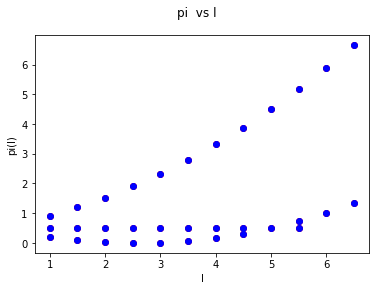

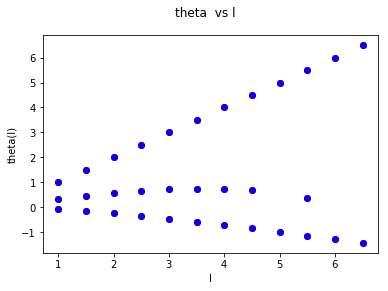

In [31]:
simult1_l.to_csv('sheets/simult1_l.csv', sep=',')
quick_plot(simult1_l,'l','simult1')

In [32]:
arg0 =  (1, .5,.5,.5,.5)
simult2_l =  l_plotter(simult,range(46,64,2),10.0, arg0, v=False)

print simult2_l

      l  lambda  mu_1  mu_2  beta_1  beta_2             theta_1  \
0   4.6       1   0.5   0.5     0.5     0.5  -0.886822521133540   
1   4.6       1   0.5   0.5     0.5     0.5                 4.6   
2   4.6       1   0.5   0.5     0.5     0.5   0.679370039680118   
3   4.8       1   0.5   0.5     0.5     0.5  -0.943126676640219   
4   4.8       1   0.5   0.5     0.5     0.5                 4.8   
5   4.8       1   0.5   0.5     0.5     0.5   0.637354648979130   
6   5.0       1   0.5   0.5     0.5     0.5   -1.00000000000000   
7   5.0       1   0.5   0.5     0.5     0.5                   5   
8   5.2       1   0.5   0.5     0.5     0.5   -1.05739845952578   
9   5.2       1   0.5   0.5     0.5     0.5                 5.2   
10  5.2       1   0.5   0.5     0.5     0.5   0.512771730569565   
11  5.4       1   0.5   0.5     0.5     0.5   -1.11528229097780   
12  5.4       1   0.5   0.5     0.5     0.5                 5.4   
13  5.4       1   0.5   0.5     0.5     0.5   0.42492235949962

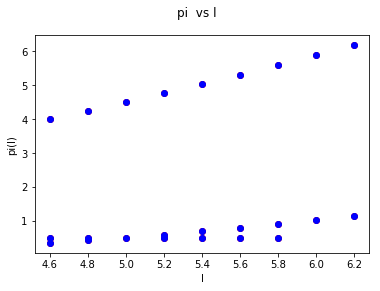

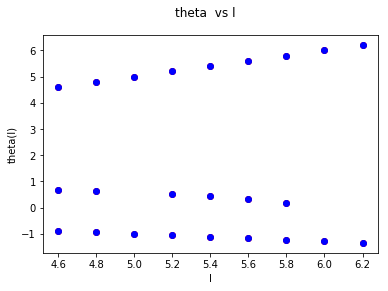

In [33]:
simult2_l.to_csv('sheets/simult2_l.csv', sep=',')
quick_plot(simult2_l,'l','simult2')

In [44]:
arg0 =  (1, .5,.5,.5,.5)
simult1_q =  q_plotter(simult,range(10,70,5),10.0, arg0)

print simult1_q

    l  lambda  mu_1  mu_2  beta_1  beta_2              theta_1  \
0   1     1.0   0.5   0.5     0.5     0.5  -0.0703675169759929   
1   1     1.0   0.5   0.5     0.5     0.5                    1   
2   1     1.0   0.5   0.5     0.5     0.5    0.306623862918075   
3   1     1.5   0.5   0.5     0.5     0.5  -0.0496305216974065   
4   1     1.5   0.5   0.5     0.5     0.5                    1   
5   1     1.5   0.5   0.5     0.5     0.5    0.316005617976297   
6   1     2.0   0.5   0.5     0.5     0.5  -0.0382923495346671   
7   1     2.0   0.5   0.5     0.5     0.5                    1   
8   1     2.0   0.5   0.5     0.5     0.5    0.320508075688773   
9   1     2.5   0.5   0.5     0.5     0.5  -0.0311589798103604   
10  1     2.5   0.5   0.5     0.5     0.5                    1   
11  1     2.5   0.5   0.5     0.5     0.5    0.323152842795195   
12  1     3.0   0.5   0.5     0.5     0.5  -0.0262613427796377   
13  1     3.0   0.5   0.5     0.5     0.5                    1   
14  1     

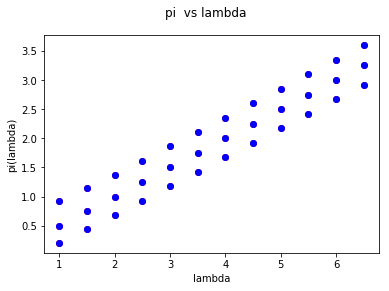

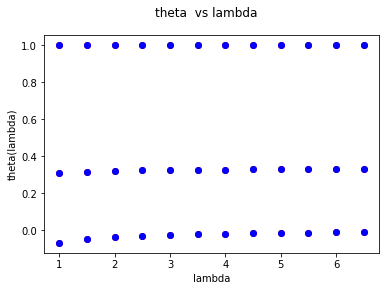

In [45]:
simult1_q.to_csv('sheets/simult1_lambda.csv', sep=',')
quick_plot(simult1_q,'lambda','simult1')

In [36]:
arg0 =  (1,1,.5,.5,.5)
simult1_m =  m_plotter(simult,range(1,10,1),10.0, arg0, v=False)
print simult1_m

    l  lambda  mu_1  mu_2  beta_1  beta_2              theta_1  \
0   1       1   0.1   0.5     0.5     0.5    -2.46410161513775   
1   1       1   0.1   0.5     0.5     0.5                    1   
2   1       1   0.2   0.5     0.5     0.5   -0.940552829515540   
3   1       1   0.2   0.5     0.5     0.5                    1   
4   1       1   0.3   0.5     0.5     0.5   -0.451680576593510   
5   1       1   0.3   0.5     0.5     0.5                    1   
6   1       1   0.4   0.5     0.5     0.5   -0.212214450449026   
7   1       1   0.4   0.5     0.5     0.5                    1   
8   1       1   0.5   0.5     0.5     0.5  -0.0703675169759929   
9   1       1   0.5   0.5     0.5     0.5                    1   
10  1       1   0.5   0.5     0.5     0.5    0.306623862918075   
11  1       1   0.6   0.5     0.5     0.5   0.0233701271062479   
12  1       1   0.6   0.5     0.5     0.5                    1   
13  1       1   0.7   0.5     0.5     0.5   0.0898992080364429   
14  1     

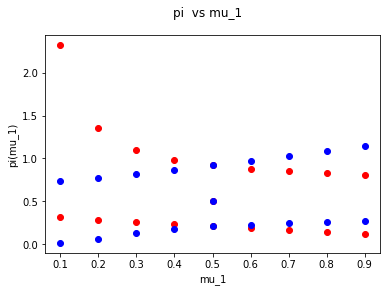

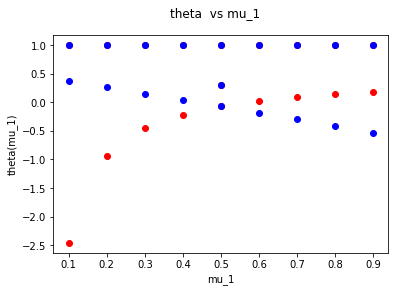

In [37]:
simult1_m.to_csv('sheets/simult1_mu.csv', sep=',')
quick_plot(simult1_m,'mu_1','simult1')

In [55]:
c=True
arg0 =  (1, .5,.5,.5,.5)
seq1_l =  l_plotter(seq,range(10,50,5),10.0, arg0, corner= c, simult=False)

print seq1_l

     l  lambda  mu_1  mu_2  beta_1  beta_2              theta_1  theta_2  \
0  1.0       1   0.5   0.5     0.5     0.5  -0.0703675169759928      1.0   
1  1.5       1   0.5   0.5     0.5     0.5   -0.145751311064591      1.5   
2  2.0       1   0.5   0.5     0.5     0.5   -0.239265962360449      2.0   
3  2.5       1   0.5   0.5     0.5     0.5   -0.346464004723152      2.5   
4  3.0       1   0.5   0.5     0.5     0.5   -0.464101615137755      3.0   
5  3.5       1   0.5   0.5     0.5     0.5   -0.589809223194882      3.5   
6  4.0       1   0.5   0.5     0.5     0.5   -0.721841686865480      4.0   
7  4.5       1   0.5   0.5     0.5     0.5   -0.858898943540673      4.5   

                pi_1                 pi_2  
0  0.920438429069628    0.206860084418966  
1   1.19905584690324    0.101888306193515  
2   1.52499487913049   0.0321509042235208  
3   1.89895229769575  0.00130962788031401  
4   2.32136720504592   0.0119661282874151  
5   2.79252193451662   0.0659824523867018  
6   3.3

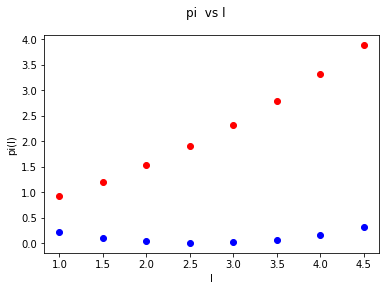

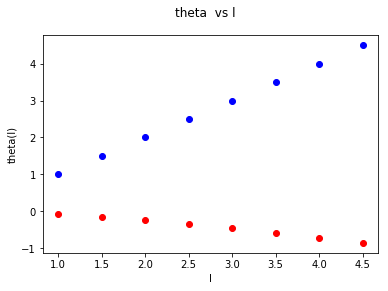

In [56]:
seq1_l.to_csv('sheets/seq1_l.csv', sep=',')
quick_plot(seq1_l,'l','seq1')

In [57]:
arg0 =  (1, .5,.5,.5,.5)
seq1_q =  q_plotter(seq,range(10,50,5),10.0, arg0, corner= c, simult=False)

print seq1_q

   l  lambda  mu_1  mu_2  beta_1  beta_2              theta_1  theta_2  \
0  1     1.0   0.5   0.5     0.5     0.5  -0.0703675169759929        1   
1  1     1.5   0.5   0.5     0.5     0.5  -0.0496305216974064        1   
2  1     2.0   0.5   0.5     0.5     0.5  -0.0382923495346667        1   
3  1     2.5   0.5   0.5     0.5     0.5  -0.0311589798103603        1   
4  1     3.0   0.5   0.5     0.5     0.5  -0.0262613427796371        1   
5  1     3.5   0.5   0.5     0.5     0.5  -0.0226921635713035        1   
6  1     4.0   0.5   0.5     0.5     0.5  -0.0199760574277785        1   
7  1     4.5   0.5   0.5     0.5     0.5  -0.0178400927370245        1   

                pi_1               pi_2  
0  0.920438429069628  0.206860084418966  
1   1.14068144175390  0.440927760622300  
2   1.37604331104217  0.683848411352395  
3   1.61734830086220  0.929908980988625  
4   1.86159104655032   1.17741681803056  
5   2.10749896343536   1.42570418772116  
6   2.35444134077767   1.67445730249249

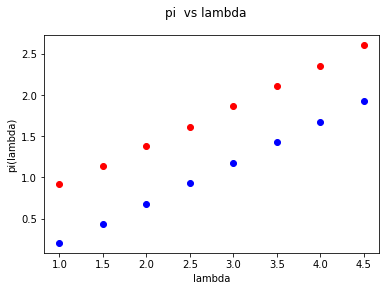

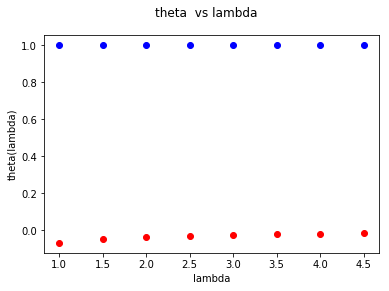

In [58]:
seq1_q.to_csv('sheets/seq1_lambda.csv', sep=',')
quick_plot(seq1_q,'lambda','seq1')

In [59]:
arg0 =  (1,1,.5,.5,.5)
seq1_m =  m_plotter(seq,range(1,10,1),10.0, arg0 ,corner= c, simult=False)

print seq1_m

   l  lambda  mu_1  mu_2  beta_1  beta_2              theta_1  theta_2  \
0  1       1   0.1   0.5     0.5     0.5    -2.46410161513775        1   
1  1       1   0.2   0.5     0.5     0.5   -0.940552829515540        1   
2  1       1   0.3   0.5     0.5     0.5   -0.451680576593510        1   
3  1       1   0.4   0.5     0.5     0.5   -0.212214450449026        1   
4  1       1   0.5   0.5     0.5     0.5  -0.0703675169759928        1   
5  1       1   0.6   0.5     0.5     0.5   0.0233701271062480        1   
6  1       1   0.7   0.5     0.5     0.5   0.0898992080364430        1   
7  1       1   0.8   0.5     0.5     0.5    0.139554320337245        1   
8  1       1   0.9   0.5     0.5     0.5    0.178027880671672        1   

                pi_1                pi_2  
0   2.32136720504592  0.0119661282874152  
1   1.35605901451300  0.0623571281693072  
2   1.10096999755666   0.133182946494323  
3  0.985708365365089   0.177565398399071  
4  0.920438429069628   0.206860084418966  
5

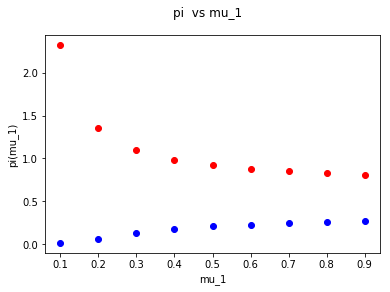

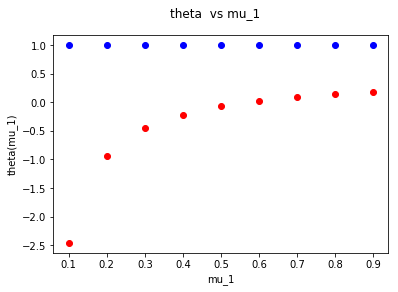

In [60]:
seq1_m.to_csv('sheets/seq1_mu.csv', sep=',')
quick_plot(seq1_m,'mu_1','seq1')